<img src="https://datascientest.fr/train/assets/logo_datascientest.png" style="height:150px"> 
<hr style="border-width:2px;border-color:##75DFC1">
<center> <h1> Projet COVID </h1> </center> <br>
<center> <h2> Troisième prototype</h2> </center> <br>
<hr style="border-width:2px;border-color:##75DFC1">

Troisième implémentation d'un CNN sur les images
<hr style="border-width:2px;border-color:##75DFC1">

>Grad-CAM

>Transfer Learning avec VGG16

Visualisation les biais du premier prototype grâce à un Grad-CAM (Gradient-weighted Class Activation Mapping), qui utilise la dernière couche de convolution pour visualiser les régions de l'image de départ qui sont "importantes" pour la prédiction du modèle.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import cv2

os.chdir('/home/baptiste/github/covid-project/COVID-19 Radiography Database')

df = pd.read_csv('img_metadata.csv', index_col = 0)

In [45]:
from functions_covid import *

In [3]:
import keras

clf = keras.models.load_model('premier_prototype.h5')

Image shape is: (256, 256)
exposure: 145.89463806152344


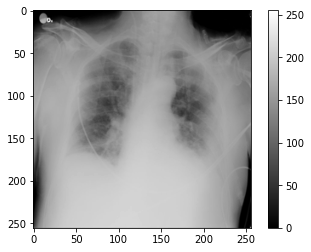

In [4]:
image_name = 'COVID/COVID (1).png'
img = cv2.imread(image_name,0)
print('Image shape is:', img.shape)
print('exposure:', np.mean(img))

plt.imshow(img,cmap='gray')
plt.colorbar();

Image shape is: (160, 160)
exposure: 0.5721086866025196


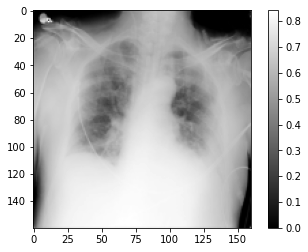

In [5]:
X = img/255
im_shape = (160, 160)
X = transform.resize(X, im_shape)

print('Image shape is:', X.shape)
print('exposure:', np.mean(X))
plt.imshow(X,cmap='gray')
plt.colorbar();

In [6]:
pred = clf.predict(X.reshape((1, 160, 160, 1)))
pred # prédit en covid

array([[1.2005110e-05, 9.9994290e-01, 4.5033874e-05]], dtype=float32)

In [7]:
print(decode_predictions(pred))

covid


Utilisons l'algorithme de Grad-CAM proposé sur le site de Keras

In [8]:
clf.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 158, 158, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 79, 79, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 77, 77, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 38, 38, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 38, 38, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 46208)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               5

In [9]:
last_conv_layer_name = "conv2d_1"
classifier_layer_names = [
    "max_pooling2d_1",
    "dropout",
    "flatten",
    "dense",
    "dropout_1",
    "dense_1"]

Predicted: covid


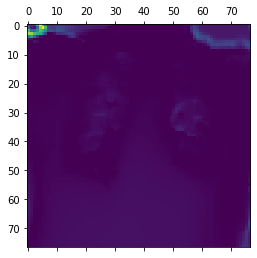

In [10]:
# Prepare image
img_array = X.reshape((1, 160, 160, 1))

# Print what the top predicted class is
pred = clf.predict(img_array)
print("Predicted:", decode_predictions(pred))

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(
    img_array, clf, last_conv_layer_name, classifier_layer_names
)

# Display heatmap
plt.matshow(heatmap)
plt.show()

On voit que sur cette image, la zone d'intérêt est concentrée sur le bord supérieur gauche, qui n'a rien à voir avec le diagnostique du covid (qui devrait être dans les poumons).

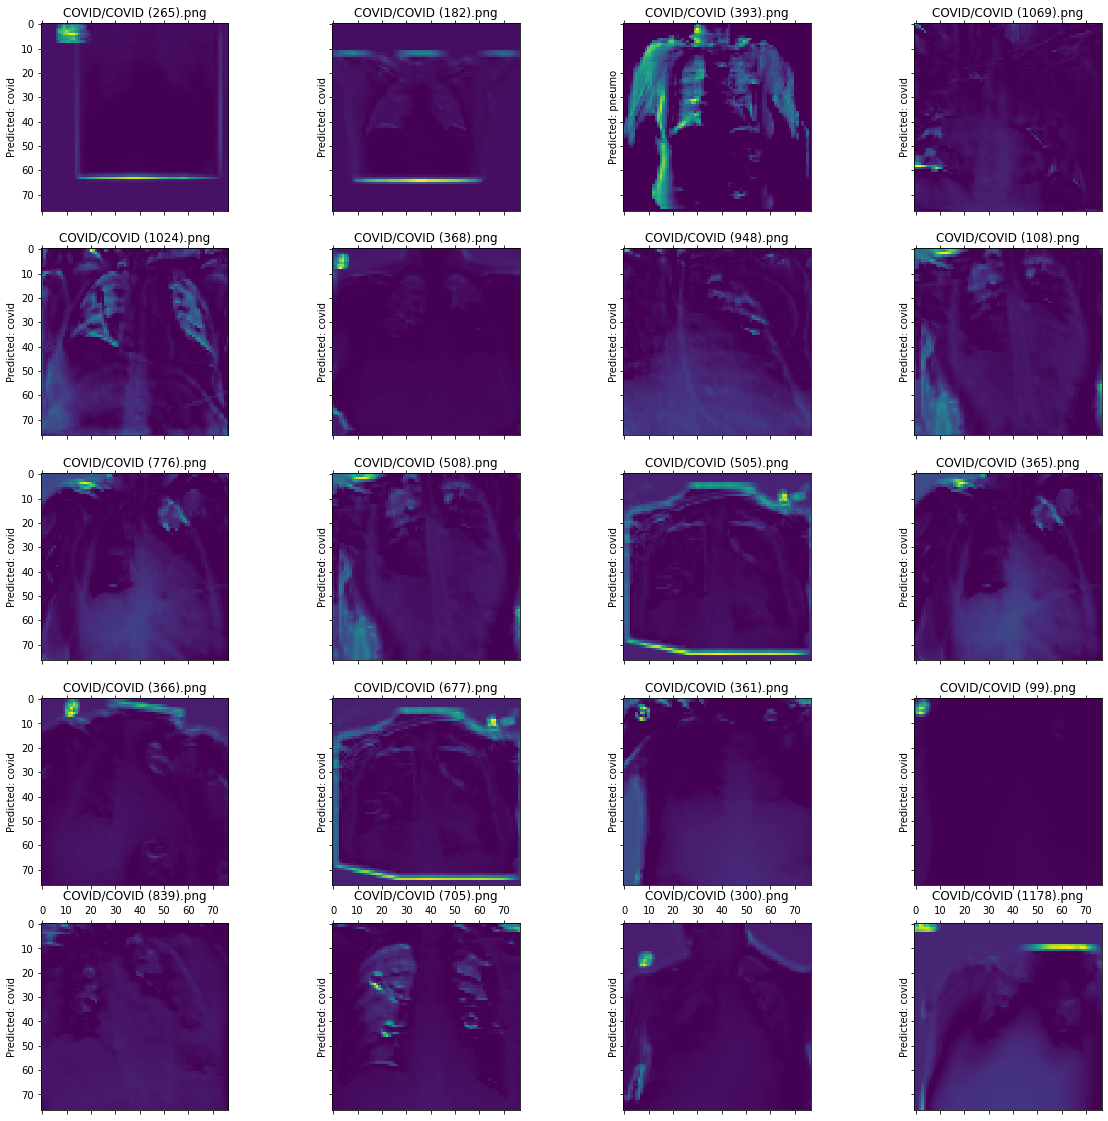

In [37]:
idx = list(df.loc[df['Class'] == 'covid', 'area'].sort_values().index)

fig, axes = plt.subplots(5, 4, figsize=(20, 20), sharex = True, sharey = True)

axes = axes.ravel()

for ii in range(20):
    image_name = idx[ii] 
    img = cv2.imread(image_name,0)
    img_array = get_img_array(img, im_shape)
    axes[ii].set_title(image_name)
    heatmap = make_gradcam_heatmap(
        img_array, clf, last_conv_layer_name, classifier_layer_names)
    axes[ii].matshow(heatmap)
    pred = clf.predict(img_array)
    axes[ii].set_ylabel("Predicted: " + decode_predictions(pred))
    

On voit que pour ces 20 images covid, le choix de l'algorithme est majoritairement réalisé grâce aux bords des images.

Deuxième prototype en transfert learning, sur le dataset avec des histogrammes équilibrés et des images croppées sur les poumons

In [11]:
os.chdir('/home/baptiste/github/covid-project/cropped_dataset/')

In [12]:
df.head()

Class  height  width  channel   B&W  luminosite  \
path                                                                     
COVID/COVID (934).png  covid   331.0  331.0      3.0  True  106.488376   
COVID/COVID (296).png  covid   256.0  256.0      3.0  True  119.666504   
COVID/COVID (74).png   covid   256.0  256.0      3.0  True  153.078995   
COVID/COVID (261).png  covid   256.0  256.0      3.0  True  186.787781   
COVID/COVID (978).png  covid   331.0  331.0      3.0  True  159.006818   

                          area  keep  
path                                  
COVID/COVID (934).png  37841.0     1  
COVID/COVID (296).png  39366.0     1  
COVID/COVID (74).png   38131.0     1  
COVID/COVID (261).png  27607.0     1  
COVID/COVID (978).png  14699.0     1

Réseau auto-encodeur UNET :

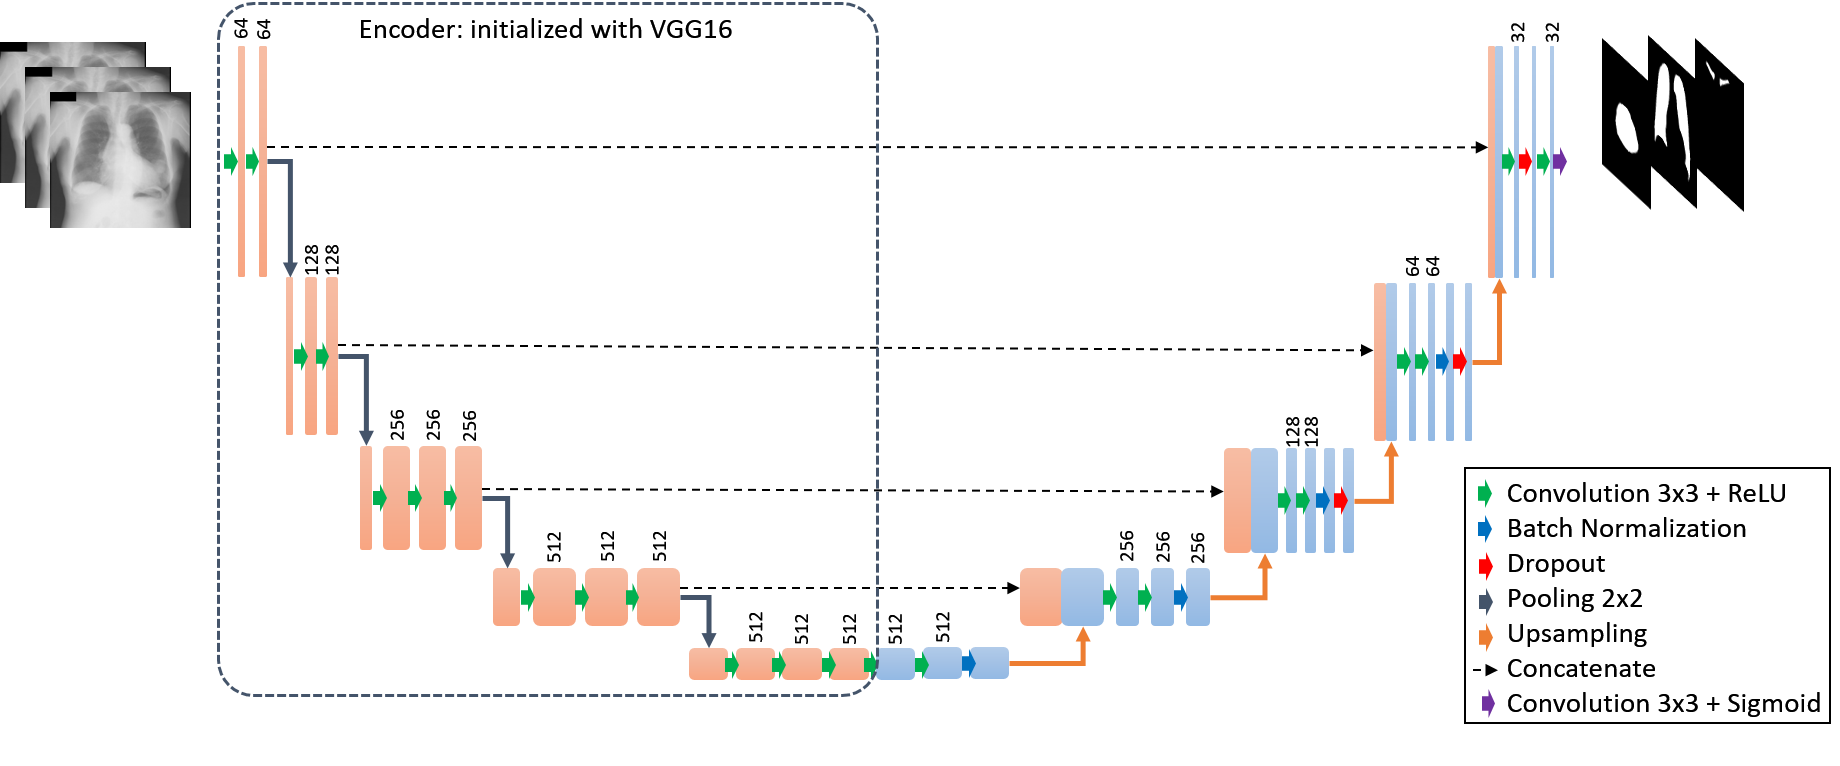

Frid-Adar, M., Ben-Cohen, A., Amer, R., & Greenspan, H. (2018). Improving the segmentation of anatomical structures in chest radiographs using u-net with an imagenet pre-trained encoder. In Image Analysis for Moving Organ, Breast, and Thoracic Images (pp. 159-168). Springer, Cham.

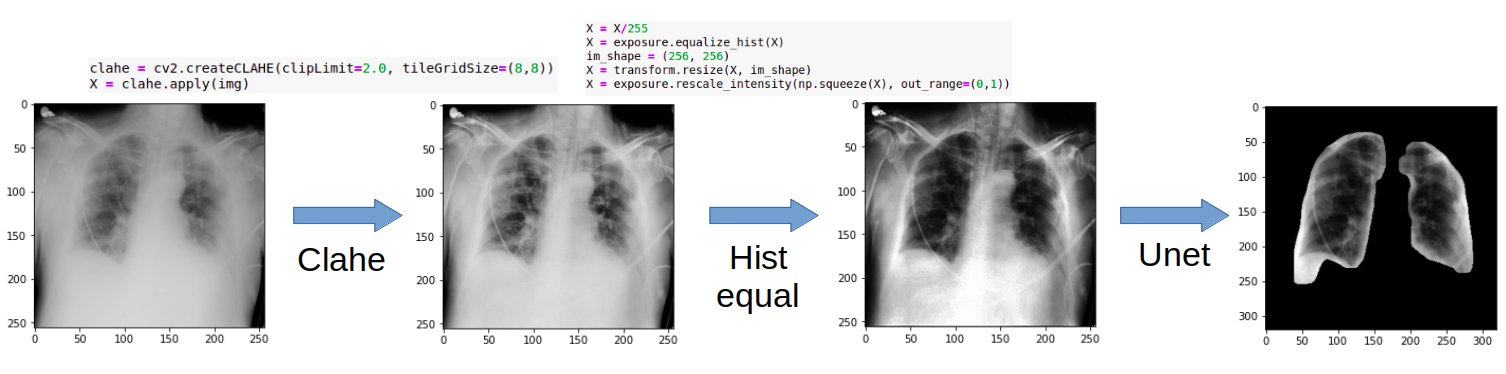

In [15]:
df.loc[image_name]

Class           covid
height            256
width             256
channel             3
B&W              True
luminosite    145.895
area            31613
keep                1
Name: COVID/COVID (1).png, dtype: object

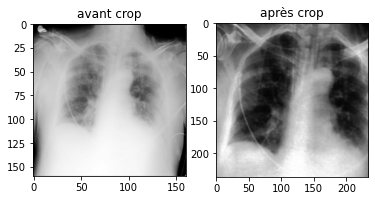

In [18]:
plt.subplot(121)
plt.imshow(X,cmap='gray')
plt.title('avant crop');

plt.subplot(122)
img = cv2.imread(image_name,0)
plt.imshow(img,cmap='gray')
plt.title('après crop');

In [21]:
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras import callbacks


from keras.layers import Input, Conv2D, Dense, Dropout
from keras.models import Model
# import keras
# from keras.optimizers import Adam
# from keras import backend as K
# import tensorflow as tf
# from skimage import transform
# from keras import optimizers

In [22]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.1,
                                   zoom_range = 0.1,
                                   rotation_range=15,                   # le plus important
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   horizontal_flip=False,               # pas de flip pour des images médicales
                                   fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale = 1./255)

In [23]:
data = df.loc[df.keep == 1, 'Class'].reset_index()
data['Class'] = data['Class'].replace({'covid' : 1, 'normal' : 0, 'pneumo' : 2})

data_train, data_test = train_test_split(data, test_size=0.2, random_state=123)

In [24]:
batch_size = 8

data_train["Class"] = data_train["Class"].astype(str)
data_test["Class"] = data_test["Class"].astype(str)

training_set = train_datagen.flow_from_dataframe(dataframe=data_train,
                                                 directory="",
                                                 x_col = "path",
                                                 y_col = "Class",
                                                 target_size = (226, 226),
                                                 batch_size = batch_size, 
                                                 color_mode='grayscale',
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_dataframe(dataframe=data_test,
                                            directory="",
                                            x_col = "path",
                                            y_col = "Class",
                                            target_size = (226, 226),
                                            batch_size = batch_size,
                                            color_mode='grayscale',
                                            class_mode = 'categorical')

Found 2988 validated image filenames belonging to 3 classes.
Found 747 validated image filenames belonging to 3 classes.


<ipython-input-24-5265b15a2885>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train["Class"] = data_train["Class"].astype(str)
<ipython-input-24-5265b15a2885>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test["Class"] = data_test["Class"].astype(str)


L'idée de la première couche de convolution (conv2d_1) est de transformer les images noir et blanc en couleur, pour tirer tout le potentiel du réseau densenet121, qui a été entrainer sur des images couleur. De plus, je suis curieux de voir comment le réseau peut "colorier" les images.

In [25]:
# Save automatically the weights
checkpoint = callbacks.ModelCheckpoint(filepath = 'checkpoint', 
                                       monitor = 'val_loss',
                                       save_best_only = True,
                                       save_weights_only = False,
                                       mode = 'min',
                                       save_freq = 'epoch')

Le problème avec l'import du VGG16, est qu'il n'est pas en premier dans le modèle, je ne peux donc pas importer à la fois les poids de imagenet et définir un input_tensor (sortie de la couche conv2d). Je vais donc faire l'import en 2 fois, d'abord pour avoir les poids imagenet, puis modifier ces poids dans le réseau de transfer learning.

In [19]:
VGG16 = tf.keras.applications.VGG16(input_shape=(224, 224, 3),
                                               input_tensor = None,
                                               include_top=False,
                                               weights='imagenet',
                                               pooling="avg")
VGG16.summary()

58892288/58889256 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [20]:
weights_0 = VGG16.get_weights()
# weights_0[0]

In [32]:
dense_input = Input(shape=(226, 226, 1))
dense_filter = Conv2D(filters = 3, kernel_size = (3, 3), padding='valid', name = 'colorize')(dense_input)
base_model = tf.keras.applications.VGG16(input_shape=None,
                                               input_tensor = dense_filter,
                                               include_top=False,
                                               weights=None,
                                               pooling="avg")

model = Model(dense_input, base_model.output)

Modification des poids dans le réseau :

In [33]:
weights_1 = model.get_weights()
for ii in range(2, len(weights_1)):
    weights_1[ii] = weights_0[ii-2]
model.set_weights(weights_1)

In [34]:
for layer in model.layers[2:]:
     layer.trainable = False    

In [35]:
x = Dense(units = 512, activation = 'relu')(model.layers[-1].output)
x = Dropout(rate=0.2)(x)
x = Dense(units = 256, activation = 'relu')(x)
x = Dropout(rate=0.2)(x)
x = Dense(units = 128, activation = 'relu')(x)
x = Dropout(rate=0.2)(x)
x = Dense(units = 64, activation = 'relu')(x)
x = Dropout(rate=0.2)(x)
x = Dense(units = 32, activation = 'relu')(x)
x = Dropout(rate=0.2)(x)
x = Dense(units = 3, activation = 'sigmoid')(x)
classifier = Model(inputs=model.input, outputs=x)

#Compilation
classifier.compile(loss = 'categorical_crossentropy', 
                   optimizer = 'adam', 
                   metrics = ['accuracy'])

classifier.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 226, 226, 1)]     0         
_________________________________________________________________
colorize (Conv2D)            (None, 224, 224, 3)       30        
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     1475

In [37]:
del VGG16
del base_model
del model

In [39]:
# Entraînement
history = classifier.fit(training_set, 
                    epochs = 5,
                   workers = -1,
                   steps_per_epoch = len(data_train)//batch_size,
                   validation_data = test_set,
                   validation_steps = len(data_test)//batch_size,
                   callbacks = [checkpoint])

Epoch 1/5
373/373 [==============================] - 619s 2s/step - loss: 0.7257 - accuracy: 0.6409 - val_loss: 0.5635 - val_accuracy: 0.7043
INFO:tensorflow:Assets written to: checkpoint/assets
Epoch 2/5
373/373 [==============================] - 618s 2s/step - loss: 0.5046 - accuracy: 0.7789 - val_loss: 0.4074 - val_accuracy: 0.8374
INFO:tensorflow:Assets written to: checkpoint/assets
Epoch 3/5
373/373 [==============================] - 618s 2s/step - loss: 0.4198 - accuracy: 0.8349 - val_loss: 0.2844 - val_accuracy: 0.8831
INFO:tensorflow:Assets written to: checkpoint/assets
Epoch 4/5
373/373 [==============================] - 619s 2s/step - loss: 0.3678 - accuracy: 0.8587 - val_loss: 0.3865 - val_accuracy: 0.8347
Epoch 5/5
373/373 [==============================] - 619s 2s/step - loss: 0.3384 - accuracy: 0.8752 - val_loss: 0.3675 - val_accuracy: 0.8562


In [40]:
classifier.save('troisieme_prototype.h5')

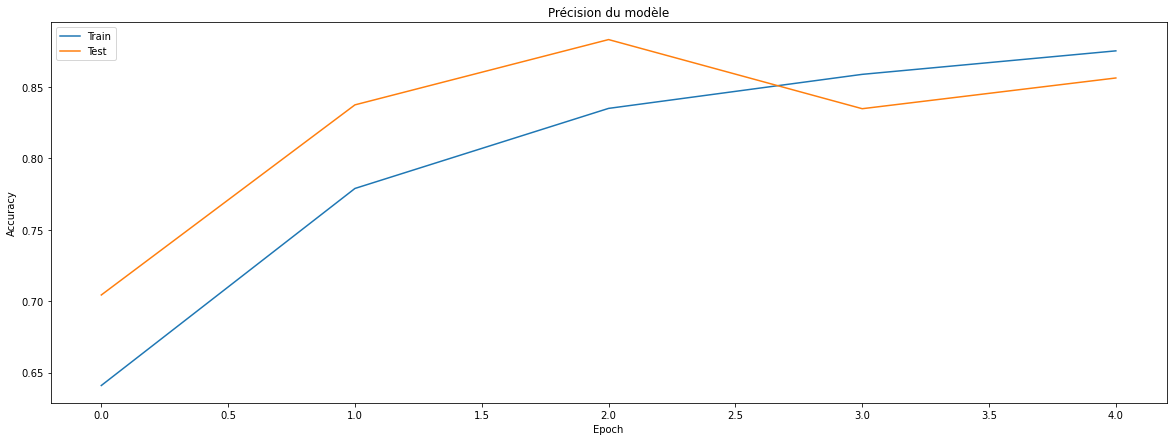

In [41]:
plt.figure(figsize = (20,7))
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Précision du modèle")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"], loc = "upper left")
plt.show()

In [93]:
classifier = keras.models.load_model('troisieme_prototype.h5')

In [94]:
for layer in classifier.layers:
    print(layer.name)

input_5
colorize
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool
global_average_pooling2d_3
dense_9
dropout_7
dense_10
dropout_8
dense_11
dropout_9
dense_12
dropout_10
dense_13
dropout_11
dense_14


In [95]:
last_conv_layer_name = "block5_conv3"
classifier_layer_names = [
    'block5_pool',
    'global_average_pooling2d_3',
    'dense_9',
    'dropout_7',
    'dense_10',
    'dropout_8',
    'dense_11',
    'dropout_9',
    'dense_12',
    'dropout_10',
    'dense_13',
    'dropout_11',
    'dense_14']

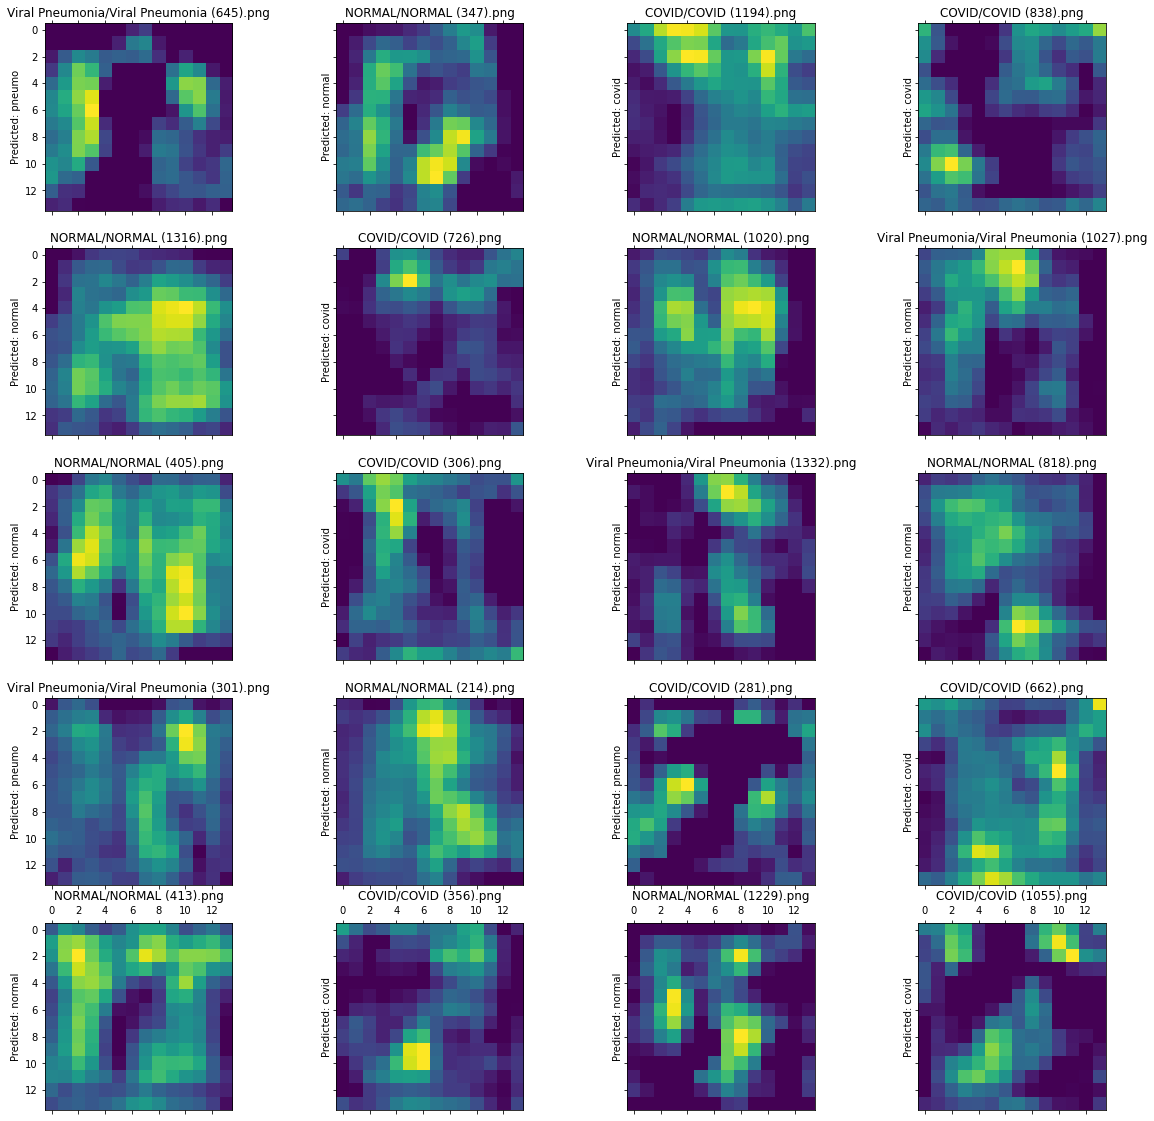

In [96]:
idx = list(df.loc[df.keep == 1].index)

idx = random.sample(idx, 20)

im_shape = (226, 226, 1)

fig, axes = plt.subplots(5, 4, figsize=(20, 20), sharex = True, sharey = True)

axes = axes.ravel()

for ii in range(20):
    image_name = idx[ii] 
    img = cv2.imread(image_name,0)
    img_array = get_img_array(img, im_shape)
    axes[ii].set_title(image_name)
    heatmap = make_gradcam_heatmap(
        img_array, classifier, last_conv_layer_name, classifier_layer_names)
    axes[ii].matshow(heatmap)
    pred = classifier.predict(img_array)
    axes[ii].set_ylabel("Predicted: " + decode_predictions(pred))
    

Utilisation d'un autre algorithme de GradCAM, qui va chercher lui-même la dernière couche de convolution

In [88]:
from GradCAM import GradCAM

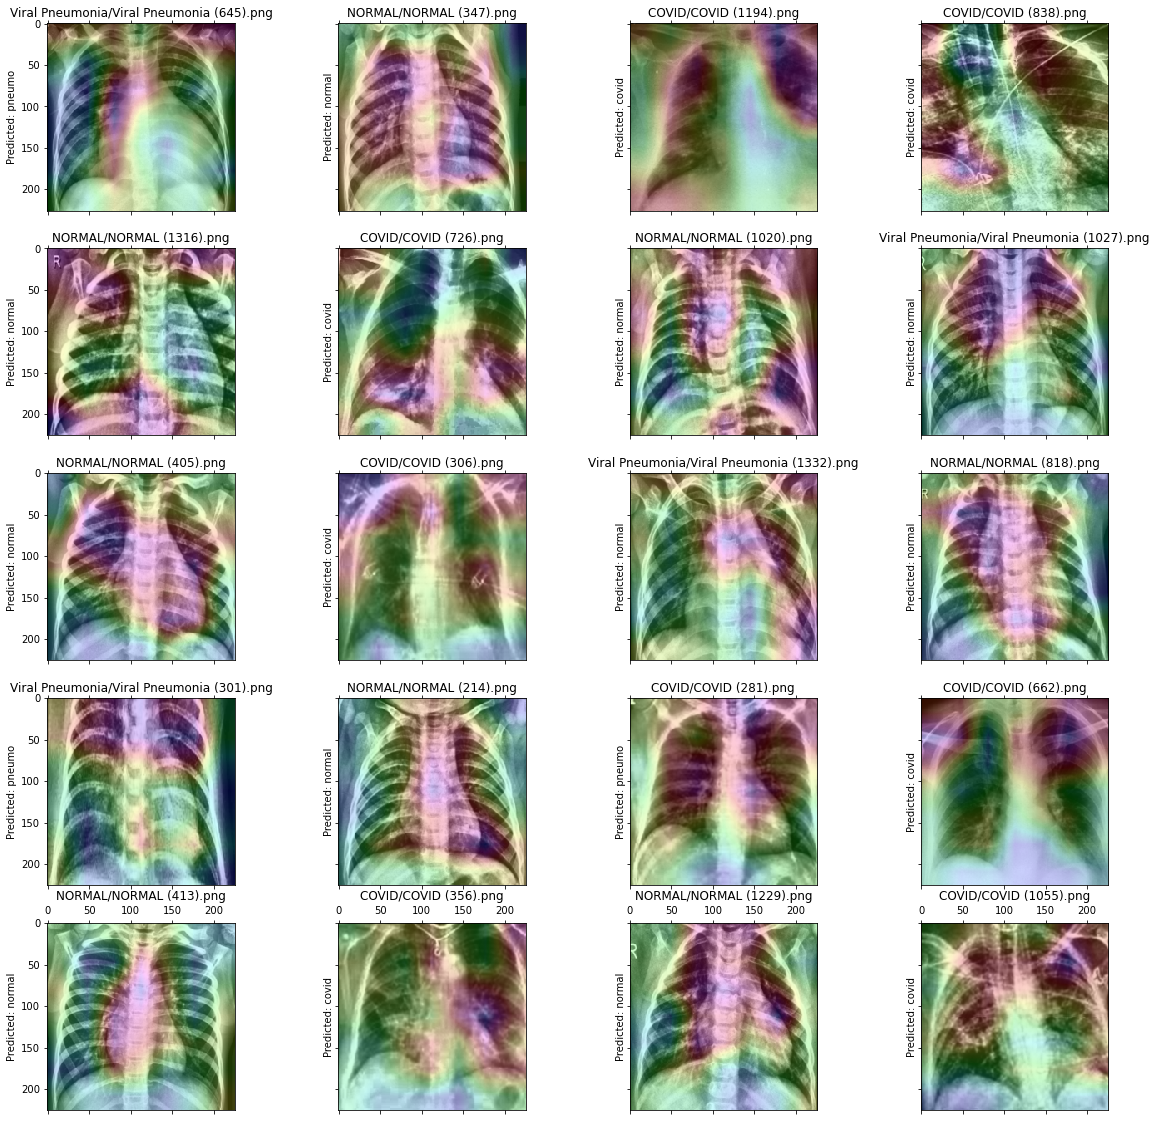

In [97]:
fig, axes = plt.subplots(5, 4, figsize=(20, 20), sharex = True, sharey = True)

axes = axes.ravel()

for ii in range(20):
    image_name = idx[ii] 
    img = cv2.imread(image_name,0)
    img_array = get_img_array(img, im_shape)
    axes[ii].set_title(image_name)
    cam = GradCAM(model=classifier, classIdx=np.argmax(pred), layerName=None)
    heatmap = cam.compute_heatmap(image=img_array[0], normalize=True)
    overlaid_heatmap = cam.overlay_heatmap(heatmap=heatmap, image=cv2.resize(img, (226,226), interpolation = cv2.INTER_AREA), alpha=0.8, 
                                           colormap=cv2.COLORMAP_HSV)
    axes[ii].matshow(overlaid_heatmap)
    pred = classifier.predict(img_array)
    axes[ii].set_ylabel("Predicted: " + decode_predictions(pred))
    

On voit que maintenant, grâce au prétraitement des images et au transfert learning, la décision du réseau est majoritairement prise grâce aux pixels des poumons

In [98]:
colorize = Model(inputs=classifier.input, outputs=classifier.layers[1].output)

In [99]:
colorize.summary()

Model: "model_282"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 226, 226, 1)]     0         
_________________________________________________________________
colorize (Conv2D)            (None, 224, 224, 3)       30        
Total params: 30
Trainable params: 30
Non-trainable params: 0
_________________________________________________________________


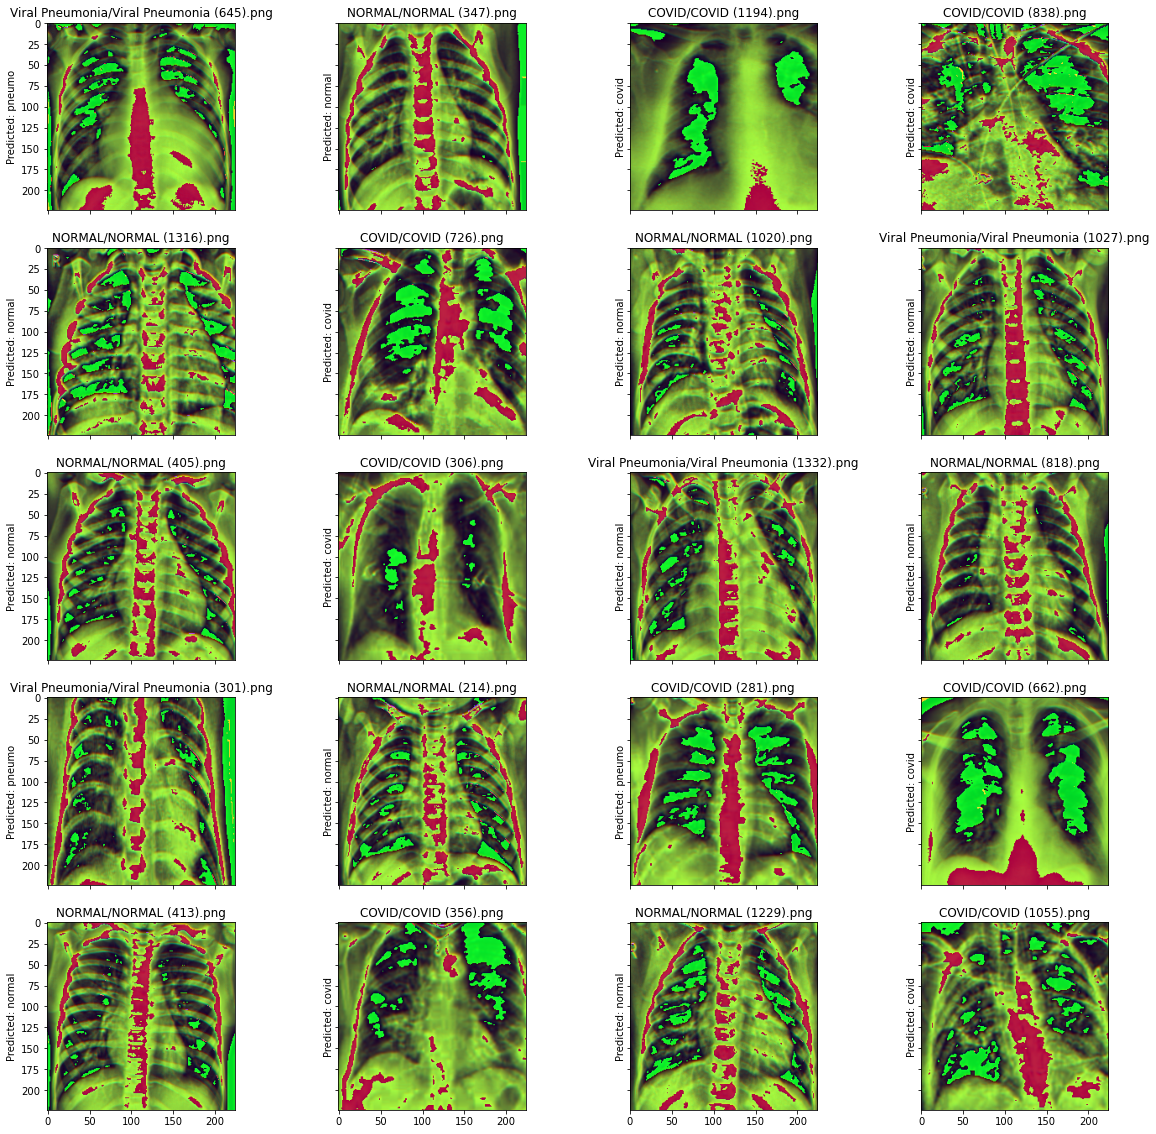

In [100]:
fig, axes = plt.subplots(5, 4, figsize=(20, 20), sharex = True, sharey = True)

axes = axes.ravel()

for ii in range(20):
    image_name = idx[ii] 
    img = cv2.imread(image_name,0)
    img_array = get_img_array(img, im_shape)
    axes[ii].set_title(image_name)
    img_color = colorize.predict(img_array)
    axes[ii].imshow((img_color[0]*255).astype(np.uint8))
    pred = classifier.predict(img_array)
    axes[ii].set_ylabel("Predicted: " + decode_predictions(pred))
    

Voici comment le réseau voit les images en couleur. On peut voir qu'il y a des choses intéressantes en vert, majoritairement présent sur les covid, mais que ce vert se retrouve sur certaine images sur les bords de l'image. On a encore ce problème de détection en bordure...